<a href="https://colab.research.google.com/github/davidogm/DataScience/blob/main/datamining/data_mining_bagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting with bagging...

## Previous steps

We import the Python libraries that we will need in this notebook


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
import random
from typing import Optional
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.tree import plot_tree

Auxiliary functions to show samples and boundaries. Extracted from https://geoffruddock.com/adaboost-from-scratch-in-python/

In [ ]:
def plot_sample_boundaries(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:
    """ Plot ± samples in 2D, optionally with decision boundary """

    assert set(y) == {-1, 1}, 'Expecting response labels to be ±1'

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

First of all, red wines features from the wine quality dataset are loaded  

In [ ]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
wines_red = pd.read_csv(dataset_url, sep=';')
wines_red['type']='red'
wines_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Now, it's the turn for the white wines...

In [ ]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
wines_white = pd.read_csv(dataset_url, sep=';')
wines_white['type']='white'
wines_white.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


Finally, we merge both to create the Wine dataset


In [ ]:
wines = pd.concat([wines_red, wines_white],ignore_index=True)
wines.head

<bound method NDFrame.head of       fixed acidity  volatile acidity  citric acid  ...  alcohol  quality   type
0               7.4              0.70         0.00  ...      9.4        5    red
1               7.8              0.88         0.00  ...      9.8        5    red
2               7.8              0.76         0.04  ...      9.8        5    red
3              11.2              0.28         0.56  ...      9.8        6    red
4               7.4              0.70         0.00  ...      9.4        5    red
...             ...               ...          ...  ...      ...      ...    ...
6492            6.2              0.21         0.29  ...     11.2        6  white
6493            6.6              0.32         0.36  ...      9.6        5  white
6494            6.5              0.24         0.19  ...      9.4        6  white
6495            5.5              0.29         0.30  ...     12.8        7  white
6496            6.0              0.21         0.38  ...     11.8        6  whit

## Preparing the dataset

We create the *quality_label* based on the quality score according to:

*   Low for less or equal to 5
*   Medium between 6 and 7
*   High for more than 7

Moreover, the *quality_binary* label is created to explain visually the bagging method



In [ ]:
wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
wines['quality_binary'] = wines.quality.apply(lambda q: -1 if q <= 5 else 1 if q > 7 else 0)
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,quality_label,quality_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,low,-1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red,low,-1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red,low,-1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red,medium,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,low,-1


*Nan* data is deleted and number of samples per quality are shown

In [ ]:
wines.dropna().quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In order to conveniently illustrate the techniques, we will proceed to simplify the dataset. For this purpose, we are only interested in samples with high and low wine quality, eliminating those of medium level. In addition, we keep only the *volatile_acidity* and *alcohol* characteristics to form a two-dimensional input space.

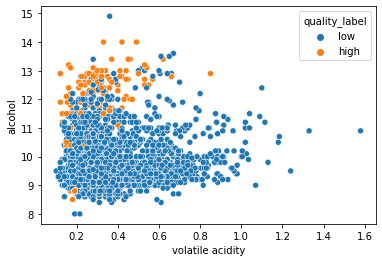

In [ ]:
wines_binary = wines.drop(wines[wines.quality_binary == 0].index)
sns.scatterplot(data=wines_binary,x="volatile acidity",y="alcohol",hue=wines_binary['quality_label'])

Since there are many more low quality samples, we will balance the dataset by keeping very few samples of both.

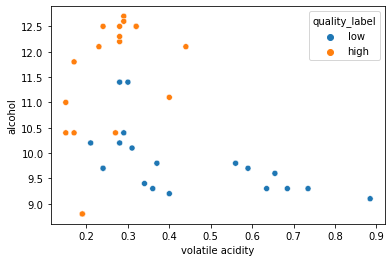

In [ ]:
g = wines_binary.groupby('quality_binary')
wines_binary_balanced = g.apply(lambda x: x.sample(int(g.size().min()/10),random_state=9).reset_index(drop=True))
sns.scatterplot(data=wines_binary_balanced,x="volatile acidity",y="alcohol",hue=wines_binary_balanced['quality_label'])

Finally, we scale the data...

In [ ]:
X=wines_binary_balanced[["volatile acidity", "alcohol"]]
y=wines_binary_balanced['quality_binary'].to_numpy()

sc = StandardScaler()
sc.fit(X)
X_scaled = pd.DataFrame(sc.transform(X),columns = X.columns)

## Bagging ensemble from scratch

We are going to generate a bagging from scratch, the code has been adapted from https://geoffruddock.com/adaboost-from-scratch-in-python/ and the book  [Machine Learning in Python: Essential Techniques for Predictive Analysis, Michael Bowles](https://www.wiley.com/en-us/Machine+Learning+in+Python%3A+Essential+Techniques+for+Predictive+Analysis-p-9781118961742)

---



In [ ]:
class Bagging:
    """ Bagging ensemble classifier from scratch """

    def __init__(self):
        self.stumps = None
        self.num_models = None
        self.n_bag_samples =  None

    def _check_X_y(self, X, y):
        """ Validate assumptions about format of input data"""
        assert set(y) == {-1, 1}, 'Response variable must be ±1'
        return X, y


The assembly consists of decision trees. We must indicate the number of models we want and the number of samples that the bootstrap will contain.


*   `X`: Data
*   `y`: labels
*   `num_models`: number of models in the ensemble
*   `n_bag_samples`: number of samples in the bootstrap for each model


In [ ]:
def fit(self, X: np.ndarray, y: np.ndarray, num_models: int, n_bag_samples: int):
    """ Fit the model using training data """

    X, y = self._check_X_y(X, y)
    n = X.shape[0]

    self.num_models = num_models
    self.stumps = np.zeros(shape=num_models, dtype=object)
    self.n_bag_samples =  n_bag_samples
    # train a series of models on random subsets of the training data

    for t in range(num_models):
        idxBag = random.sample(range(len(X)), n_bag_samples)
        xTrainBag = [X[i] for i in idxBag]
        yTrainBag = [y[i] for i in idxBag]

        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        stump = stump.fit(xTrainBag, yTrainBag)

        self.stumps[t] = stump

    return self

The prediction function combines the decisions of the models by means of a voting system. In this case, all have the same weight and the function is the mode.

In [ ]:
def predict(self, X):
    """ Make predictions using already fitted model """
    stump_preds = np.array([stump.predict(X) for stump in self.stumps])
    return stats.mode(stump_preds)[0]

The classification and results in two-dimensional feature space are shown below:

Train error: 13.2%


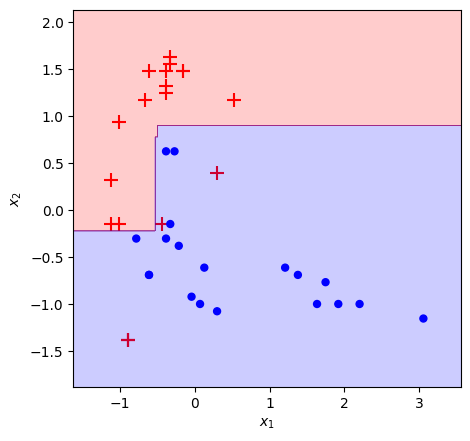

In [ ]:
# assign our individually defined functions as methods of our classifier
Bagging.fit = fit
Bagging.predict = predict

num_models = 10
n_bag_samples=int(len(y)*0.5)
clf = Bagging().fit(X=X_scaled.to_numpy(), y=y, num_models=num_models, n_bag_samples=n_bag_samples)

plot_sample_boundaries(X_scaled.to_numpy(), y, clf)
train_err = (clf.predict(X_scaled.to_numpy()) != y).mean()
print(f'Train error: {train_err:.1%}')

Finally, we show the stumps that make up the ensemble


In [ ]:
nrows=int(num_models/2)
ncols = 2
fig, axes = plt.subplots(figsize=(8, num_models*3),
                             nrows=nrows,
                             ncols=ncols,
                             sharex=True,
                             dpi=100)
for r in range(nrows):
  for c in range(ncols):
    i=r*ncols+c
    plot_tree(clf.stumps[i], feature_names=X_scaled.columns, class_names=["Low","High"], filled=True,ax=axes[r][c])
    axes[r][c].title.set_text("Model " + str(i))

## Very simple with **scikit-learn**

In [ ]:
from sklearn.ensemble import BaggingClassifier

num_models=10
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2),n_estimators=num_models,max_samples=0.5, max_features=0.5)

In [ ]:
clf = bagging.fit(X_scaled.to_numpy(), y)
plot_sample_boundaries(X_scaled.to_numpy(), y, clf)

train_err = (clf.predict(X_scaled.to_numpy()) != y).mean()
print(f'Train error: {train_err:.1%}')

In [ ]:
nrows=int(num_models/2)
ncols = 2

fig, axes = plt.subplots(figsize=(8, num_models*3),
                             nrows=nrows,
                             ncols=ncols,
                             sharex=True,
                             dpi=100)
for r in range(nrows):
  for c in range(ncols):
    i=r*ncols+c
    plot_tree(bagging.estimators_[i], class_names=["Low","High"], filled=True,ax=axes[r][c])
    axes[r][c].title.set_text("Model " + str (i) + " with feature " + str(bagging.estimators_features_[i][0]))

## In action...

**1.** Modify the [predict function](https://colab.research.google.com/drive/1av5WZ4AwxGgPzFHET5XEcOKVFtsLJuc5?authuser=2#scrollTo=fAGGZ-x1bQNf&line=2&uniqifier=1) to consider soft voting according to the class probabilities of each model

**2.** Modify the [fit function](https://colab.research.google.com/drive/1av5WZ4AwxGgPzFHET5XEcOKVFtsLJuc5?authuser=2#scrollTo=kD9_pST6bM6P&line=1&uniqifier=1) to consider also the sampling of features

# Referencias


*   [Machine Learning in Python: Essential Techniques for Predictive Analysis, Michael Bowles](https://www.wiley.com/en-us/Machine+Learning+in+Python%3A+Essential+Techniques+for+Predictive+Analysis-p-9781118961742)
*   [Wines dataset](https://www.kaggle.com/mgmarques/wines-type-and-quality-classification-exercises)
*   [Functions to show data space and boundaries](https://geoffruddock.com/adaboost-from-scratch-in-python/)